In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ugradio
import astropy.coordinates
import astropy.time
import time
import astropy.io.fits as fits

No module named 'scipy'


In [2]:
%matplotlib inline
import pylab as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import warnings
warnings.filterwarnings("ignore")

ImportError: cannot import name 'dedent' from 'matplotlib.cbook' (C:\Users\olivi\Anaconda33\envs\UGRADIO1\lib\site-packages\matplotlib\cbook\__init__.py)

In [ ]:
m = Basemap(projection='ortho',lat_0=90,lon_0=180,rsphere=1.)
lons,lats = m.makegrid(500,500) # 500 lons by 500 lats

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('Orthographic (Longitude)')
m.imshow(lons, vmin=-180, vmax=180)
m.drawmapboundary()
m.drawmeridians(lon_lines, labels=[1,1,1,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:])
plt.colorbar()

plt.subplot(122)
plt.title('Orthographic (Latitude)')
m.imshow(lats, vmax=-90, vmin=90)
m.drawmapboundary()
m.drawmeridians(lon_lines, labels=[1,1,1,1], labelstyle='+/-')
m.drawparallels(np.arange(-90,90,30)[1:])
plt.colorbar()
plt.show()

In [2]:
data_noise_on = []
data_noise_off = []

In [3]:
data_noise_off_example = fits.open('../Data/celestial_pole-noiseoff_' + str(0) + '.fits')

In [4]:
for i in range(0, 386):
    d_off_avg = []
    d_on_avg = []
    for j in range(1, 21):
        d_off = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + '.fits')
        d_off = d_off[j].data['auto0_real']
        d_off_avg.append(d_off)
    d_off_avg = np.mean(d_off_avg, axis=0)
    data_noise_off.append(d_off_avg)
    
    for k in range(1, 3):
        d_on = fits.open('../Data/celestial_pole-noiseon_' + str(i) + '.fits')[k].data['auto0_real']
        d_on_avg.append(d_on)
    d_on_avg = np.mean(d_on_avg, axis=0)
    data_noise_on.append(d_on_avg)

In [5]:
hdr = dict(data_noise_off_example[0].header)
if_freq = 144 + np.arange(0, hdr['NCHAN']) * hdr['RES'] / 1e6
rf_freq = if_freq + 2*635

# this is wrong and stupid
data_noise_on_average = np.mean(data_noise_on, axis=0)
data_noise_off_average = np.mean(data_noise_off, axis=0)

<IPython.core.display.Javascript object>


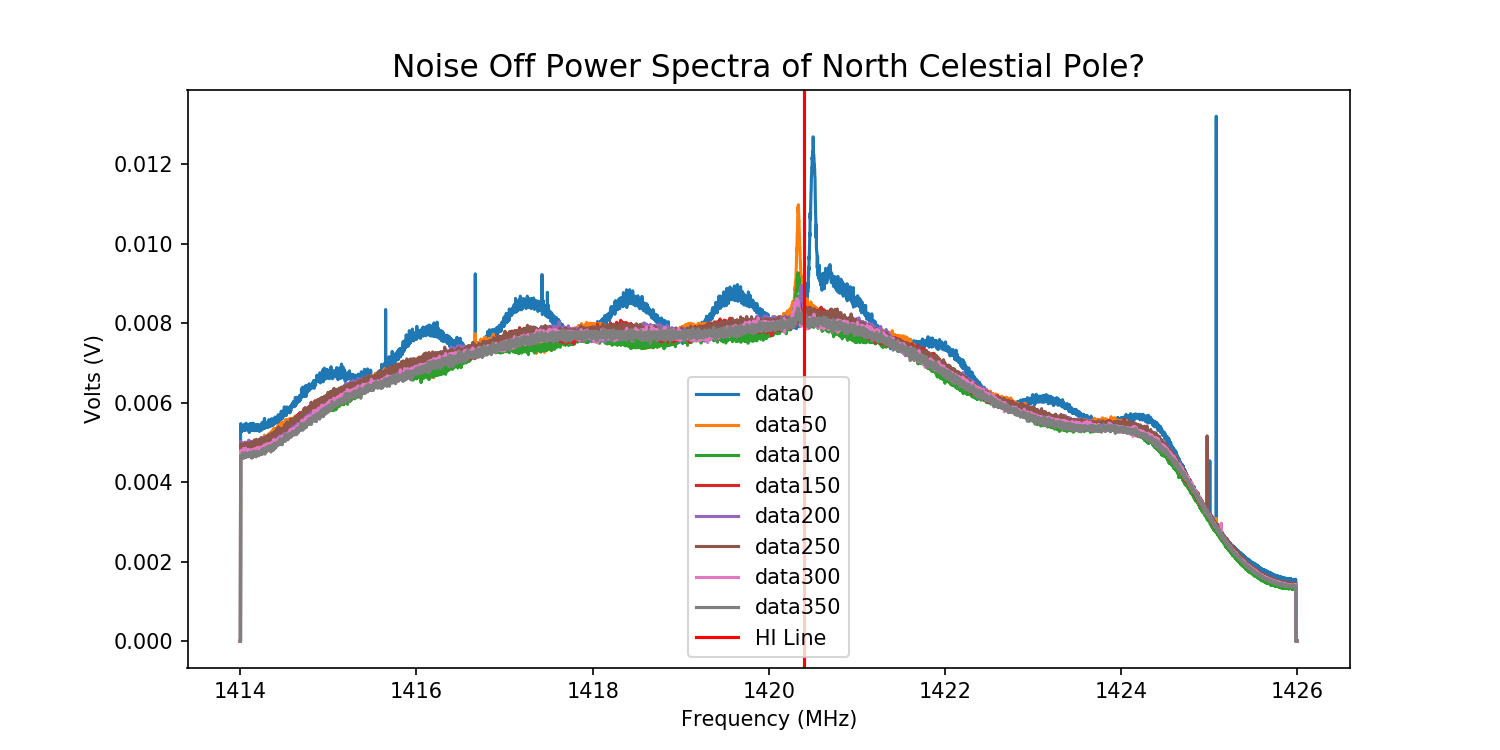

In [12]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in range(0,386,50):
    
    #plt.plot(rf_freq, data_noise_on[i], label='ON')
    plt.plot(rf_freq, data_noise_off[i], label='data'+str(i))

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise Off Power Spectra of North Celestial Pole?', fontsize=15)
plt.legend()

#redshifted 

<IPython.core.display.Javascript object>


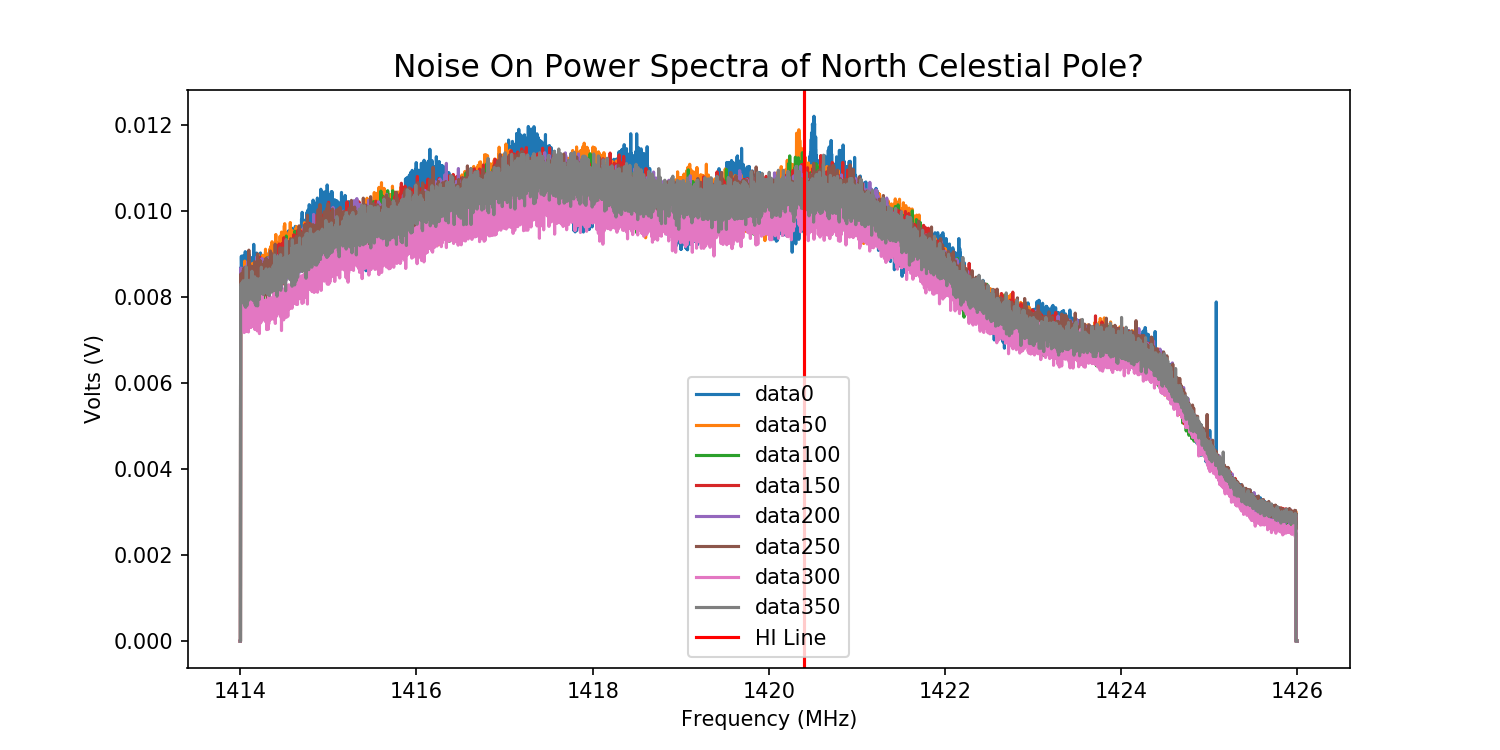

In [13]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in range(0,386,50):
    
    plt.plot(rf_freq, data_noise_on[i], label='data'+str(i))
    #plt.plot(rf_freq, data_noise_off[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise On Power Spectra of North Celestial Pole?', fontsize=15)
plt.legend()

#redshifted 
#cut off ends of the data

# Calibration 

# JEN: CALIBRATION PT. 1

In [14]:
import tqdm 

In [15]:
data_noise_on[i].shape[0]

8192

<IPython.core.display.Javascript object>


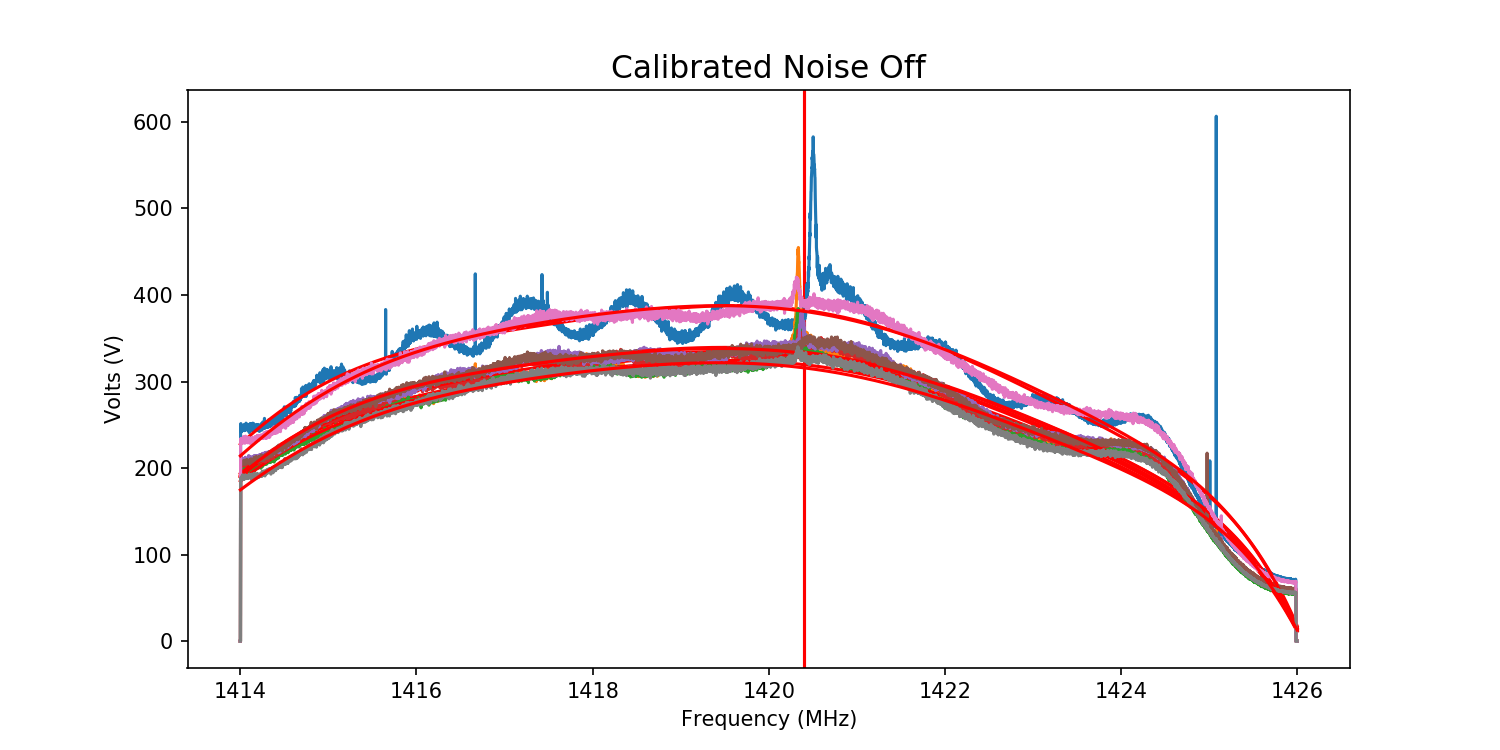

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 82.05it/s]


In [16]:
# are these values correct?
t_noise = 90
t_sys = 2.5

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Calibrated Noise Off', fontsize=15)

for i in tqdm.tqdm(range(0, 386,50)):
    
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.plot(rf_freq, g*(s_line), label='ON') #off

    plt.plot(rf_freq, g*fit, "r")

<IPython.core.display.Javascript object>


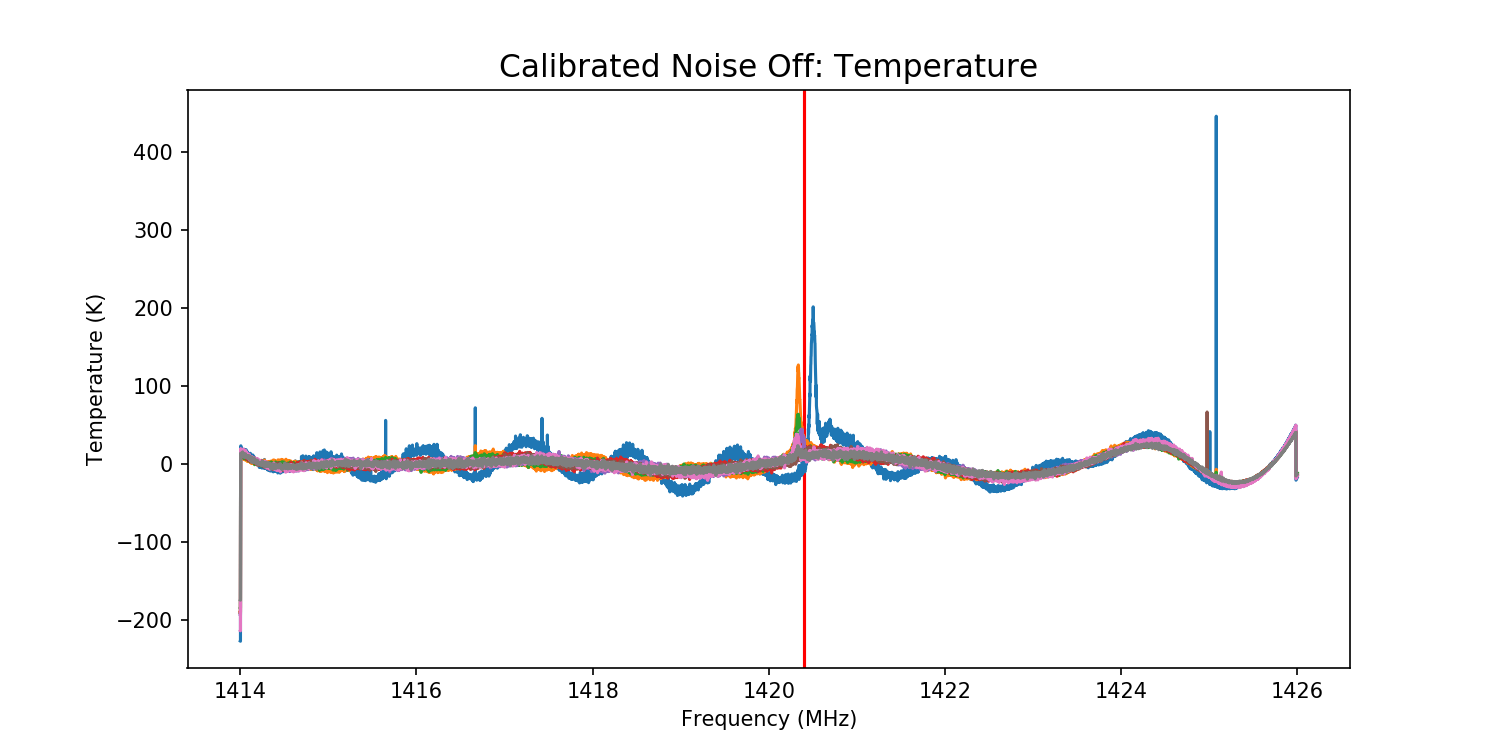

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 135.78it/s]


In [11]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Calibrated Noise Off: Temperature', fontsize=15)

for i in tqdm.tqdm(range(0, 386,50)):
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.plot(rf_freq, g*(s_line - fit), label='ON') #off

# OLIVIA: CALIBRATION PT.2

<IPython.core.display.Javascript object>


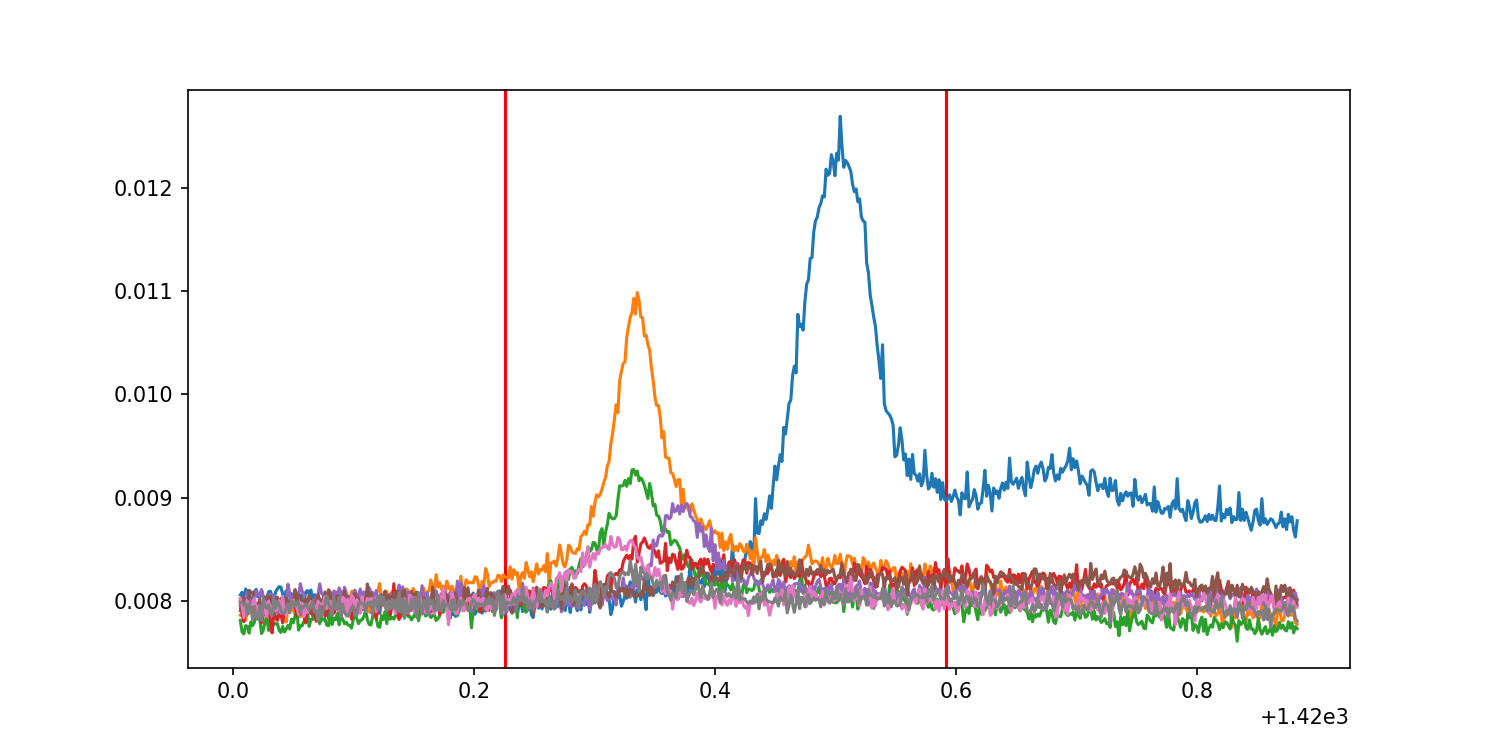

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 364.60it/s]


In [17]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.axvline(rf_freq[4250], color='r', label='Line')
plt.axvline(rf_freq[4500], color='r', label='Line')
for i in tqdm.tqdm(range(0, 386,50)):
    plt.plot(rf_freq[4100:4700], data_noise_off[i][4100:4700])
    
#1420.29 to 1420.56: bounds on H lines


<IPython.core.display.Javascript object>


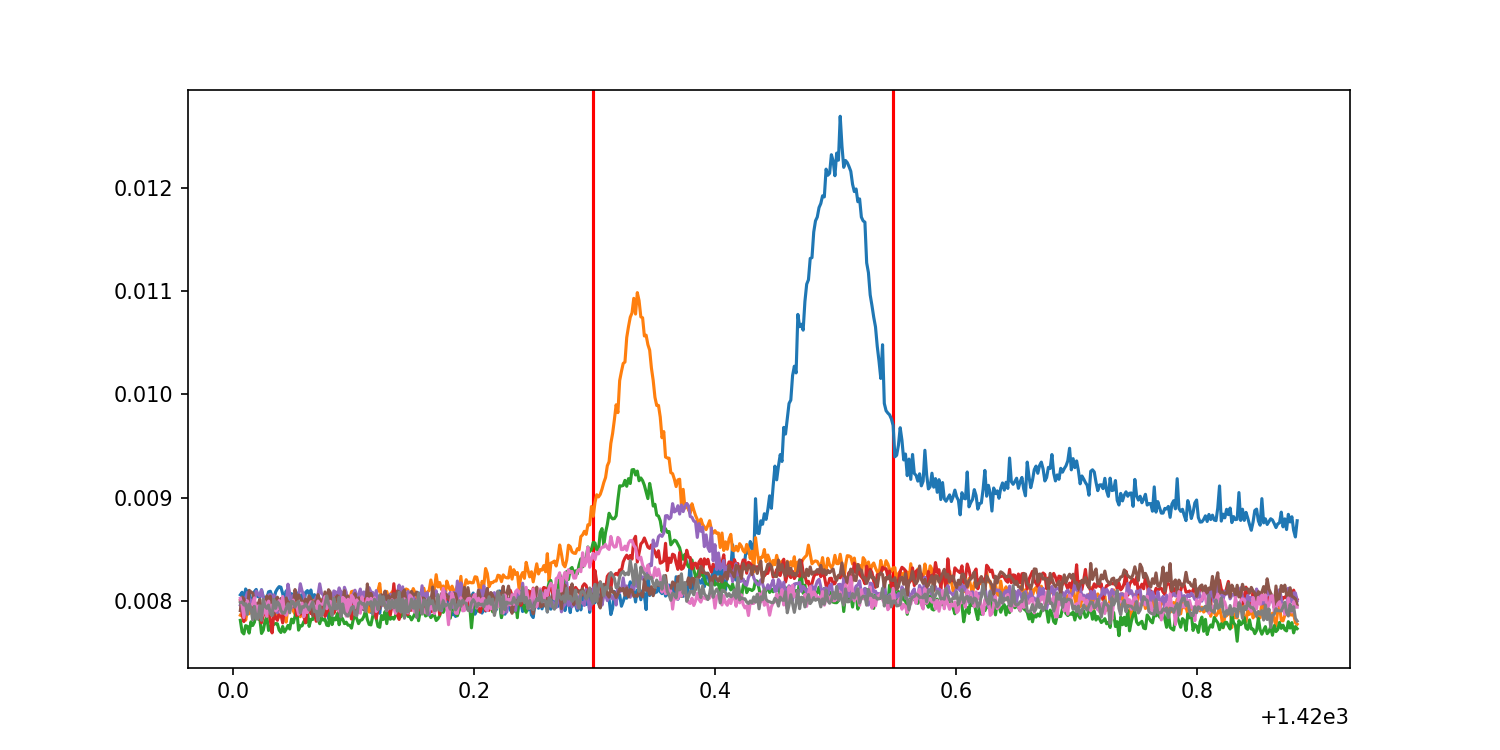

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 420.87it/s]


In [27]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.axvline(rf_freq[4300], color='r', label='Line')
plt.axvline(rf_freq[4470], color='r', label='Line')
for i in tqdm.tqdm(range(0, 386,50)):
    plt.plot(rf_freq[4100:4700], data_noise_off[i][4100:4700])

<IPython.core.display.Javascript object>


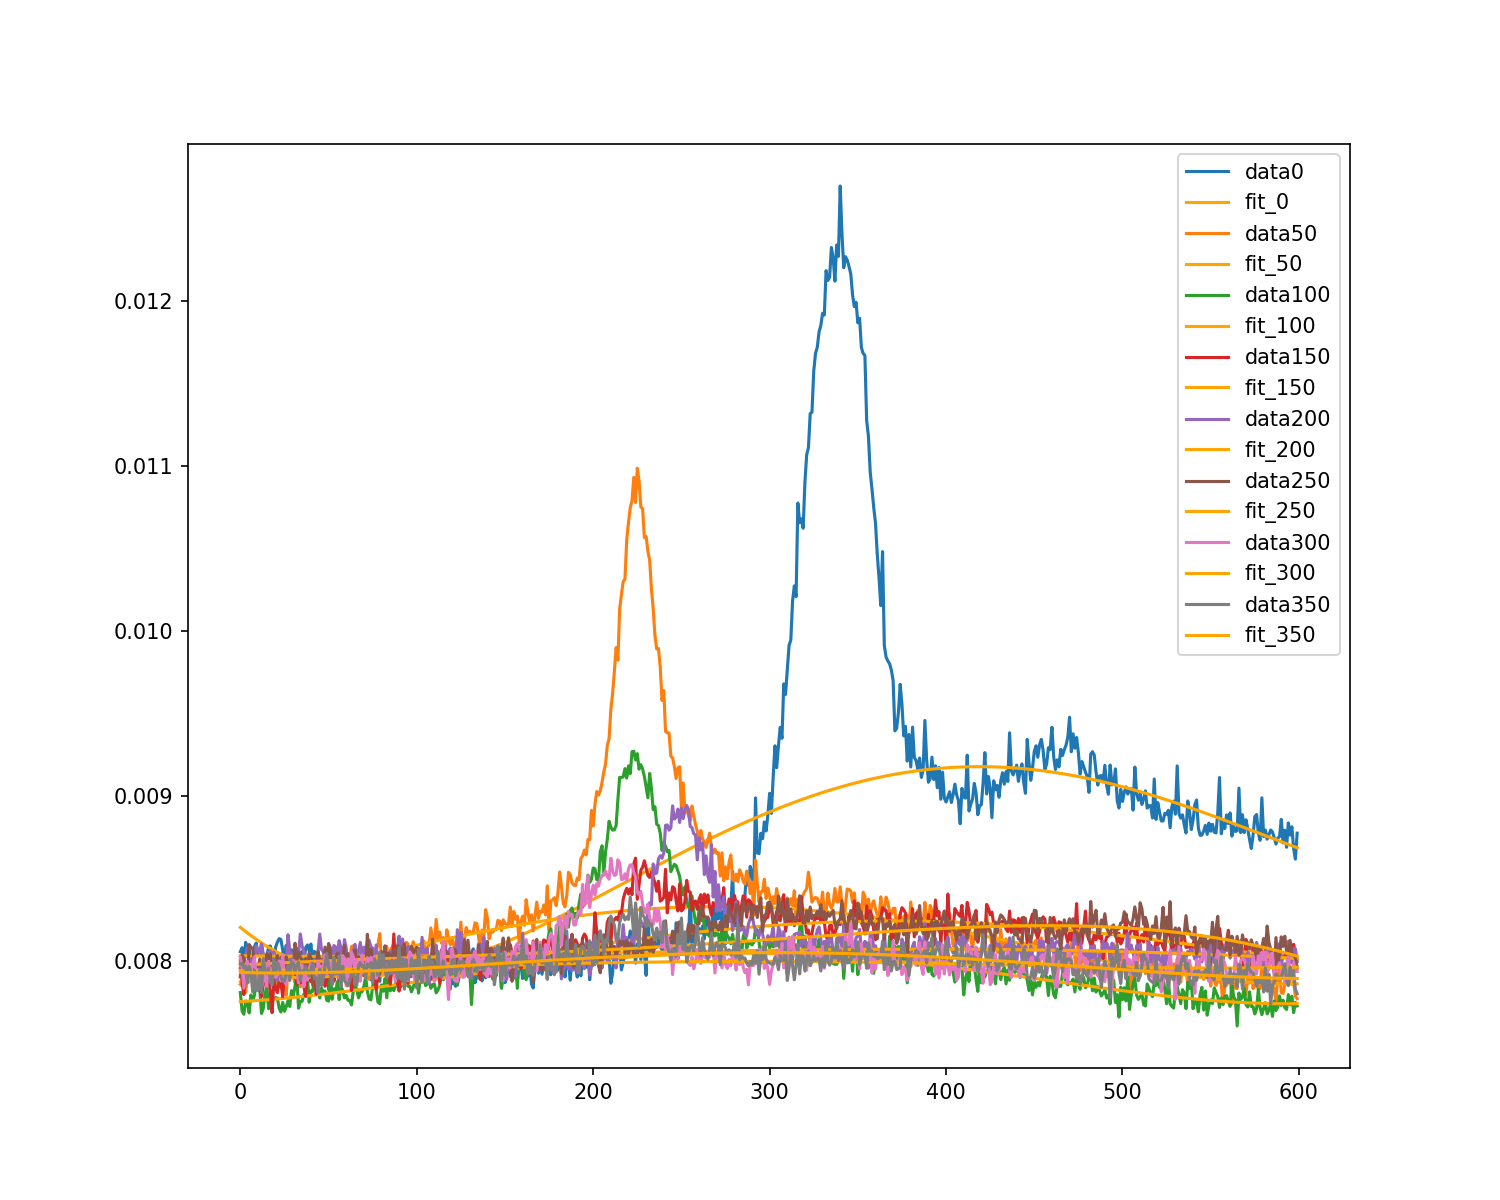

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.23it/s]


In [25]:
%matplotlib notebook
plt.figure(figsize=(10,8))
for i in tqdm.tqdm(range(0, 386,50)):
    fit_arr = np.hstack([data_noise_off[i][4100:4250], data_noise_off[i][4470:4700]])
    xarr = np.hstack([np.arange(4100, 4250), np.arange(4470, 4700)])
    p = np.polyfit(xarr, fit_arr, 4)
    pfit = np.polyval(p, np.arange(4100, 4700))
    plt.plot(data_noise_off[i][4100:4700], label='data'+ str(i))
    plt.plot(pfit, color='orange', label='fit_'+str(i))
plt.legend()

<IPython.core.display.Javascript object>


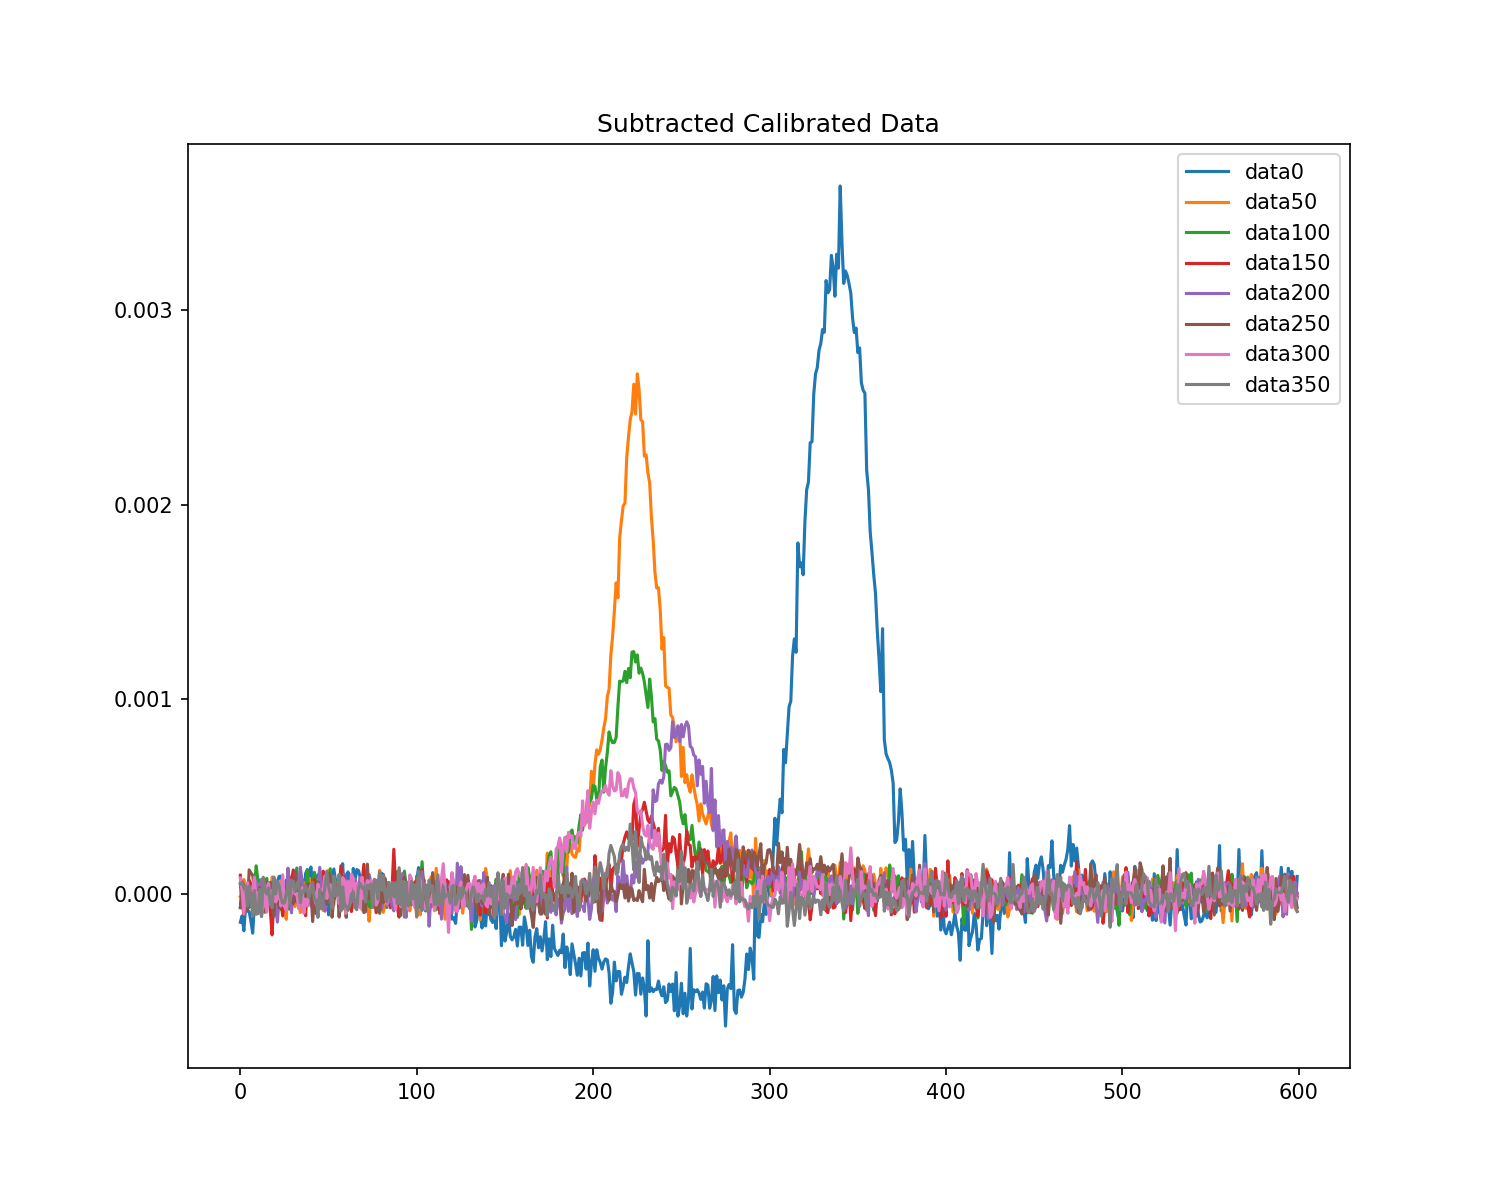

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.82it/s]


In [26]:
%matplotlib notebook
plt.figure(figsize=(10,8))
for i in tqdm.tqdm(range(0, 386,50)):
    fit_arr = np.hstack([data_noise_off[i][4100:4250], data_noise_off[i][4500:4700]])
    xarr = np.hstack([np.arange(4100, 4250), np.arange(4470, 4700)])
    p = np.polyfit(xarr, fit_arr, 4)
    pfit = np.polyval(p, np.arange(4100, 4700))
    plt.plot(data_noise_off[i][4100:4700] - pfit, label='data'+ str(i))
plt.title('Subtracted Calibrated Data')
plt.xlabel('')
plt.legend()

#what are the next steps to calibrate the whole signal

In [59]:
#there is still ripple gain

#get rid by fitting region where the spike is not

#spike will be at different - look at a few spectra and see where spike moves to, how much it changes
#how fast do we expect the area around the north celecstial pole to 
#use that to find out how redshfited/ doppler shifted the object is 

#exclude frequencies -- use cursor to find right and left bounds on frequency on 5 or 10 random files -- break them up
#polyfit exluding peak but include region set around peak
#to make sure our peak is closer to zero

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(np.log10(spectra_array[:,400:600]),vmin=-4,vmax=-0.6,cmap='magma',aspect='auto',interpolation= 'gaussian', extent=[freq[0],freq[-1],times[-1]-times[0],0]) #xfirst then y
plt.colorbar()
plt.xlabel()
plt.ylabel()
